# Jeremy notebook for final project

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import k_means
from helpers import *
%load_ext autoreload
%autoreload 2

## Table segmentation

### Segmentation Helpers 

In [64]:
reduction_factor = 30 #30
table_im_big = cv2.imread("data/train/train_19.jpg")
target_size = (int(table_im_big.shape[1]/reduction_factor),
               int(table_im_big.shape[0]/reduction_factor))
table_im = cv2.resize(table_im_big,target_size)

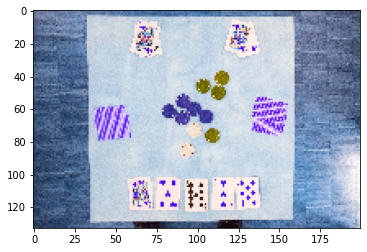

In [65]:
plt.imshow(table_im)

## Segmentation pipeline

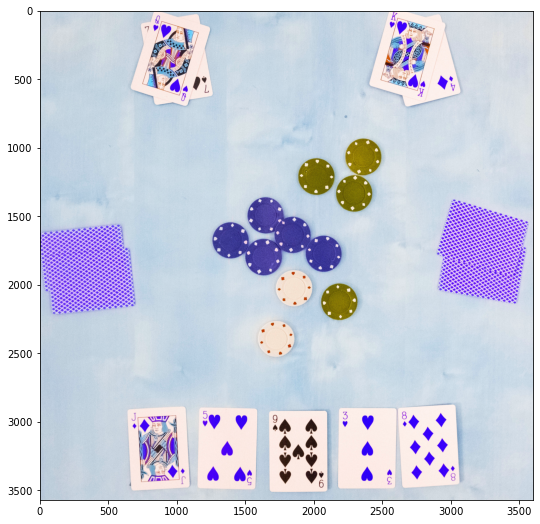

In [66]:
gray_sobel = cv2.cvtColor(sobel_filter(table_im,balance=1), cv2.COLOR_BGR2GRAY)
log = LoG(gray_sobel,sigma=1,tr=20)
### Detect center
kernel = np.ones((7,7))
inverse_log = -log + 1
start_mask = cv2.morphologyEx(inverse_log, cv2.MORPH_OPEN, kernel)
x_center, y_center = start_mask.shape[0]/2,start_mask.shape[1]/2
start_indices = zip(np.where(start_mask == 1)[0],np.where(start_mask == 1)[1])
start = sorted(start_indices,key=lambda l: np.power((l[0]-x_center,l[1]-y_center),2).sum())[0]
### Segment table
kernel = np.ones((3,3))
inverse_log = cv2.morphologyEx(inverse_log, cv2.MORPH_OPEN, kernel)
segmentation = np.zeros(inverse_log.shape,dtype=np.uint8)
for i in iterative_grow(inverse_log,start[0],start[1],0.5):
    segmentation[i[0],i[1]] = 255
corners = retrieve_corners_alt(segmentation)
table_segmentation = extract_table_alt(table_im_big,corners,reduction_factor)
fig,ax = plt.subplots(figsize=(16,9))
ax.imshow(table_segmentation)

## Card Classifier

In [ ]:
def extract_symbol(data_path):
    

Current image: the shape of image=(7569, 3), the data type=float64.
The current iteration of kmeans is: 0, the average loss is 782.9077817413132.


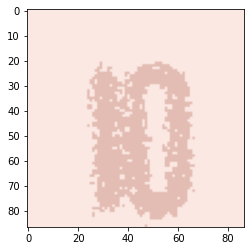

In [41]:
reduction_factor = 1 #30
spades_cards = cv2.imread("data/symbols/10_2.jpg")
target_size = (int(spades_cards.shape[1]/reduction_factor),
               int(spades_cards.shape[0]/reduction_factor))
spades_cards_small = cv2.resize(spades_cards,target_size)
plt.imshow(k_means.kmean_compression(spades_cards,k=2))
#plt.imshow(cv2.Canny(spades_cards,200,300))

# DeNoiser

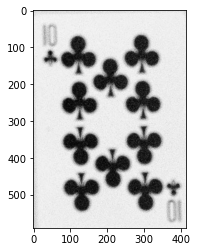

In [52]:
reduction_factor = 1 #30
noisy_im_big = cv2.imread("data/symbols/test_image_2.jpg")
noisy_im_big = noisy_im_big[430:1020,50:465]
target_size = (int(noisy_im_big.shape[1]/reduction_factor),
               int(noisy_im_big.shape[0]/reduction_factor))
noisy_im = cv2.resize(noisy_im_big,target_size)
noisy_im = cv2.cvtColor(noisy_im, cv2.COLOR_BGR2GRAY)
plt.imshow(noisy_im)

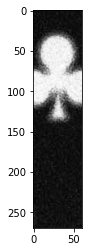

In [55]:
noise = noisy_im[100:370,180:240]
noise = noise - noise.mean()
plt.imshow(noise,cmap="Greys")

In [56]:
# https://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/VELDHUIZEN/node15.html
# Wiener Filter
from scipy.signal import convolve2d as conv2
import scipy.fft
# Unaffected image
im = noisy_im

# PSF filter
h_PSF = np.ones((1, 1))
#h_PSF = np.ones(1)
H_PSF = scipy.fft.fft2(h_PSF, s=im.shape)

#im = conv2(im, h_PSF, 'same')

# Spectras for autocorr
im_autocorr = scipy.signal.correlate2d(im, im,"same")
noise_autocorr = scipy.signal.correlate2d(noise, noise, "same")
im_autocorr_fft = scipy.fft.fft2(im_autocorr)
noise_autocorr_fft = scipy.fft.fft2(noise_autocorr, s=im.shape)
# Assembling wiener filter
H_wiener = np.conjugate(H_PSF)/(np.power(np.abs(H_PSF),2) + (noise_autocorr_fft/im_autocorr_fft))

# Restoring using wiener filter
im_fft = scipy.fft.fft2(im)
im_restored_fft = im_fft*H_wiener
im_restored = np.abs(scipy.fft.ifft2(im_restored_fft))
im_restored = im_restored.astype(np.uint8)

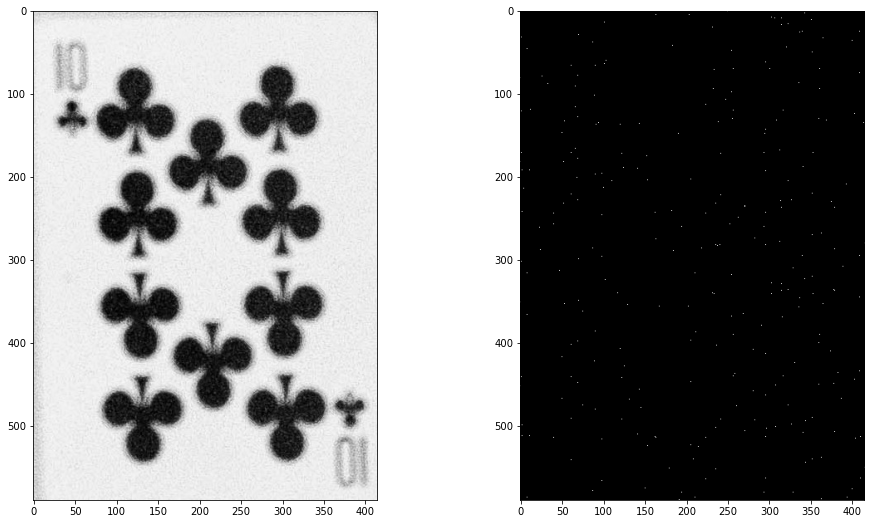

In [57]:
fig,axs = plt.subplots(1,2,figsize=(16,9))
axs[0].imshow(im)
axs[1].imshow(im_restored)

# Symbol recognition

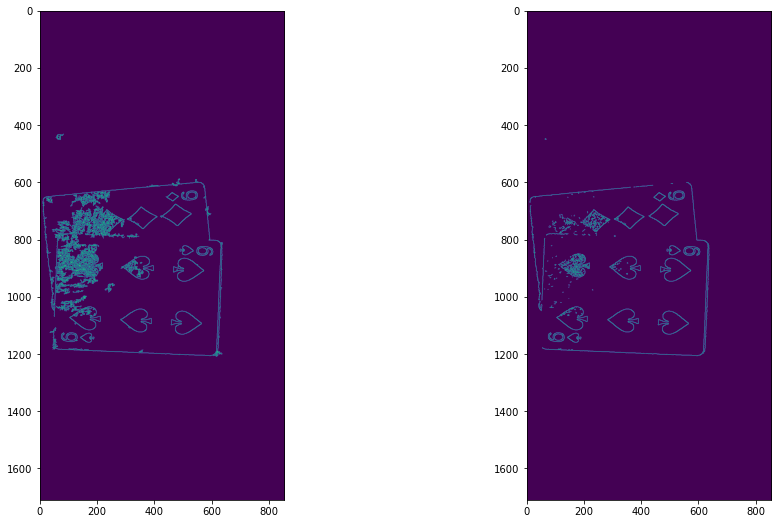

In [17]:
w,h,_ = table_segmentation.shape
left_wing_big = table_segmentation[w//4:3*w//4,0:h//4]
reduction_factor = 1 #30
target_size = (int(left_wing_big.shape[1]/reduction_factor),
               int(left_wing_big.shape[0]/reduction_factor))
left_wing = cv2.resize(left_wing_big,target_size)
fig,ax = plt.subplots(1,2,figsize=(16,9))
ax[0].imshow(cv2.Canny(left_wing,50,300))
ax[1].imshow(cv2.Canny(left_wing,200,300))

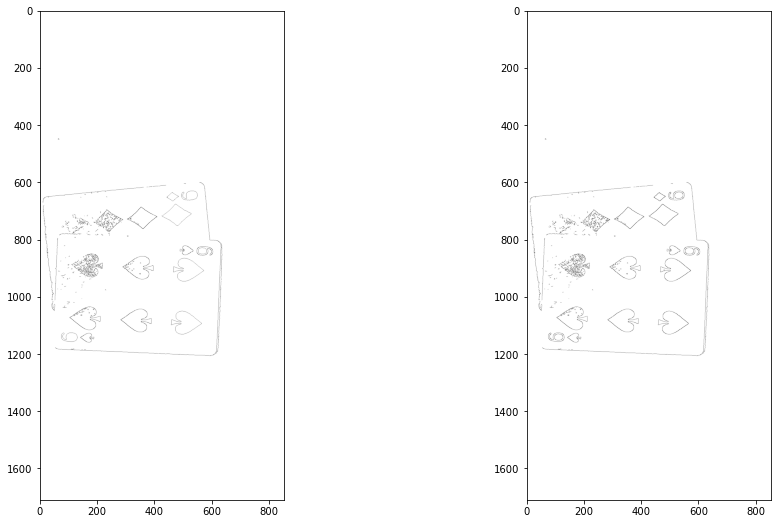

In [28]:
image_edges = cv2.Canny(left_wing,200,300)
im2, contours = cv2.findContours(image_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
mask = np.zeros(image_edges.shape,np.uint8)
for i in im2:
    for j in i:
        mask[j[0][1],j[0][0]] = 1
fig,ax = plt.subplots(1,2,figsize=(16,9))
ax[0].imshow(mask,cmap="Greys")
ax[1].imshow(image_edges,cmap="Greys")
kernel = np.ones((2,2))
#mask = cv2.morphologyEx(mask, cv2.MORPH_C, kernel)

In [10]:
shapes = shape_detector(cv2.Canny(left_wing,200,300))
print(f"We retrieved {len(shapes)} shapes.")

KeyboardInterrupt: 

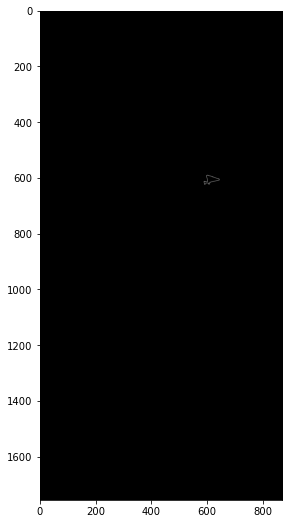

In [117]:
shape_test = shapes[2]
fig,ax = plt.subplots(figsize=(16,9))
#ax.imshow(cv2.Canny(left_wing,200,300)[500:650,450:650],cmap="gray")
ax.imshow(shape_test,cmap="gray")

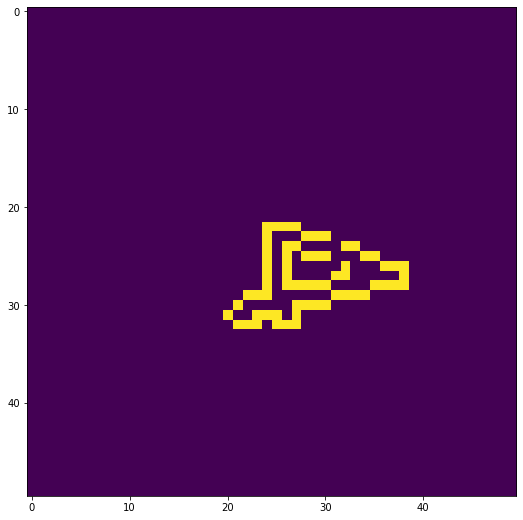

In [43]:
shape_test = shapes[1][175:225,175:225]
fig,ax = plt.subplots(figsize=(16,9))
ax.imshow(shape_test)

In [44]:
ret, thresh = cv2.threshold(shape_test, 127, 255, 0)

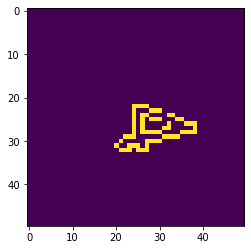

In [45]:
plt.imshow(thresh)

In [1]:
im2, contours = cv2.findContours(shape_test, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

NameError: name 'cv2' is not defined

In [2]:
mask = np.zeros(shape_test.shape,np.uint8)
for i in im2:
    for j in i:
        mask[j[0][1],j[0][0]] = 1
kernel = np.ones((2,2))
#mask = cv2.morphologyEx(mask, cv2.MORPH_C, kernel)

NameError: name 'np' is not defined

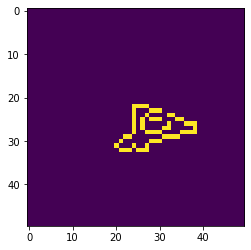

In [65]:
plt.imshow(mask)

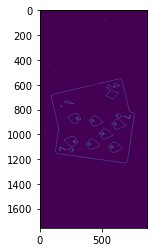

In [70]:
plt.imshow(get_contour(cv2.Canny(left_wing,200,300)))

# Pytesseract Tests

In [ ]:
import pytesseract

In [23]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
text = pytesseract.image_to_string(digit_image)

In [24]:
text

''

## Segmentation Tests

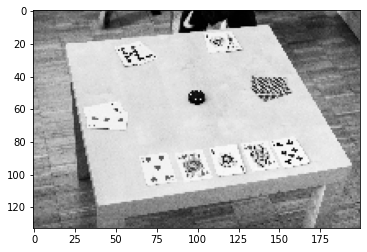

In [12]:
gray = cv2.cvtColor(table_im, cv2.COLOR_BGR2GRAY)
plt.imshow(gray,cmap="gray")

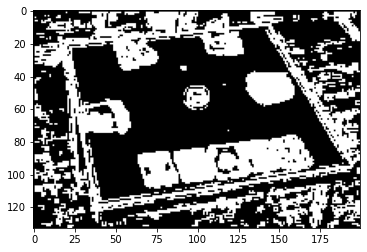

In [13]:
plt.imshow(LoG(table_im,tr=20))

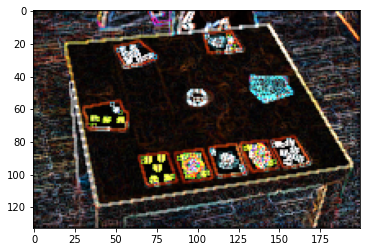

In [14]:
plt.imshow(sobel_filter(table_im,balance=1))

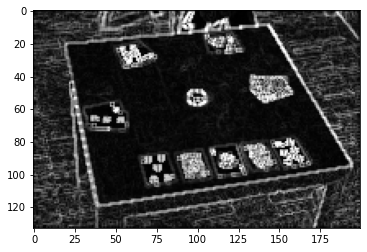

In [15]:
gray = cv2.cvtColor(sobel_filter(table_im,balance=1), cv2.COLOR_BGR2GRAY)
plt.imshow(gray,cmap="gray")

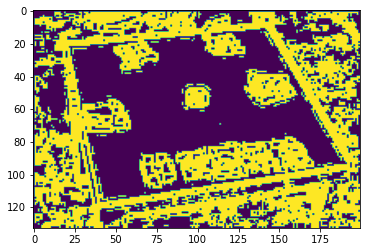

In [16]:
test_log = LoG(gray,sigma=1,tr=20)
plt.imshow(test_log)

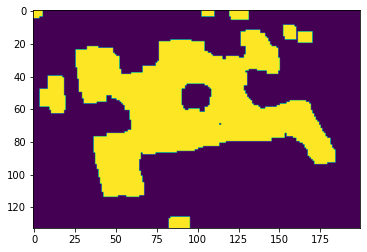

In [61]:
kernel = np.ones((7,7))
start_mask = cv2.morphologyEx(a, cv2.MORPH_OPEN, kernel)
plt.imshow(start_mask)
x_center, y_center = start_mask.shape[0]/2,start_mask.shape[1]/2
start_indices = zip(np.where(start_mask == 1)[0],np.where(start_mask == 1)[1])
start = sorted(start_indices,key=lambda l: np.power((l[0]-x_center,l[1]-y_center),2).sum())[0]

In [67]:
test_segmentation = np.zeros(test_log.shape,dtype=np.uint8)
for i in iterative_grow(-test_log,start[0],start[1],-0.5):
    test_segmentation[i[0],i[1]] = 255

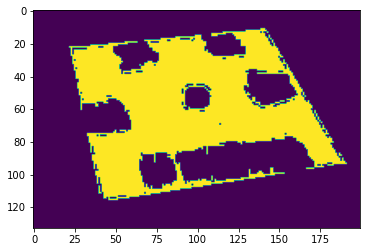

In [68]:
plt.imshow(test_segmentation)

In [70]:
corners = retrieve_corners_opt(test_segmentation)
corners

((13, 143), (93, 191), (111, 40), (22, 22))

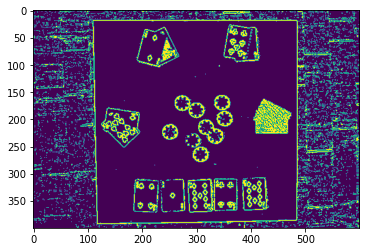

In [48]:
sobel_table = sobel_filter(table_im,balance=1)
edge_mask = np.zeros(sobel_table.shape[:-1])
edge_mask[sobel_table.sum(axis=-1) > 200] = 1
plt.imshow(edge_mask)

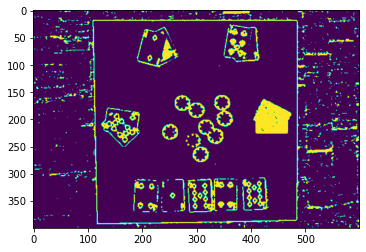

In [49]:
plt.imshow(median_filter(edge_mask,k=3))

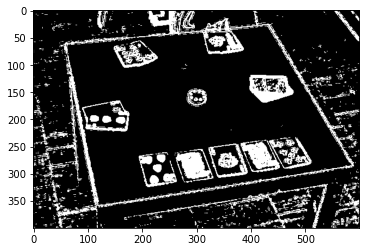

In [47]:
plt.imshow(LoG(table_im,tr=20))

Current image: the shape of image=(26600, 3), the data type=float64.
The current iteration of kmeans is: 0, the average loss is 14551.006353383458.
The current iteration of kmeans is: 10, the average loss is 2720.806783781768.


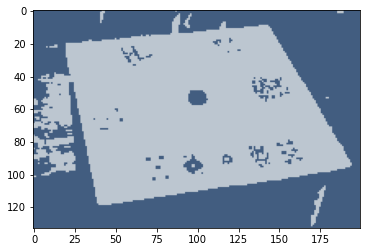

In [5]:
table_smooth = cv2.GaussianBlur(table_im,(0,0),0.7)
table_compressed = k_means.kmean_compression(table_smooth,k=2)
plt.imshow(table_compressed)

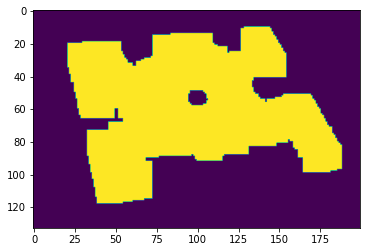

In [7]:
edge_mask = np.zeros(table_compressed.shape[:-1])
edge_mask[(table_compressed > 120)[:,:,0]] = 1
#kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(51,51))
kernel = np.ones((15,15))
edge_mask = cv2.morphologyEx(edge_mask, cv2.MORPH_OPEN, kernel)
plt.imshow(edge_mask)

Current image: the shape of image=(1423575, 1), the data type=float64.
The current iteration of kmeans is: 0, the average loss is 640.2769604692412.
The current iteration of kmeans is: 10, the average loss is 253.58459855478736.


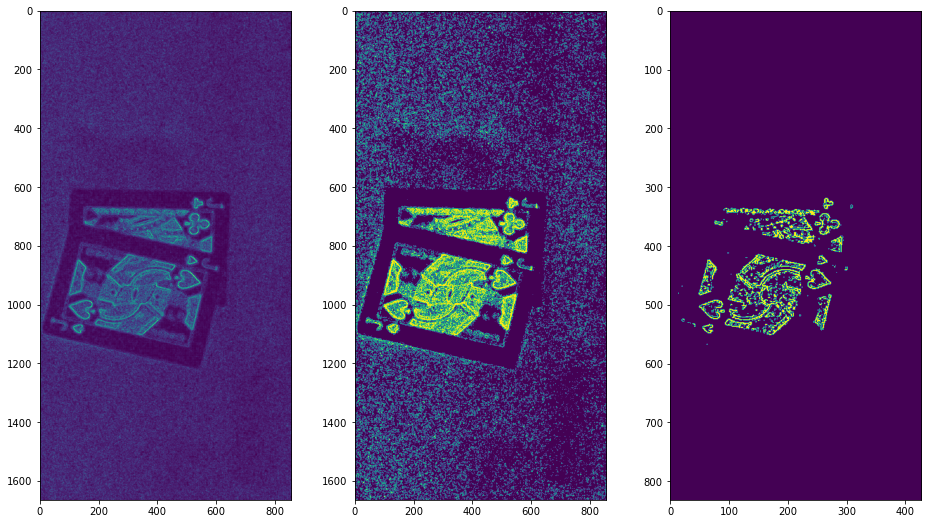

In [119]:
gray_sobel = cv2.cvtColor(sobel_filter(left_wing,balance=1), cv2.COLOR_BGR2GRAY)
#log = LoG(gray_sobel,sigma=1,tr=20)
#log_alt = LoG(cv2.cvtColor(left_wing, cv2.COLOR_BGR2GRAY),sigma=1,tr=20)
fig,ax = plt.subplots(1,3,figsize=(16,9))
ax[0].imshow(gray_sobel)
ax[1].imshow(create_k_mean_mask(gray_sobel))
ax[2].imshow(log_alt)